In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

In [3]:
df = pd.read_csv('/content/drive/MyDrive/TimeSeries/Gemini_ETHUSD_d.csv',  
                 skiprows=1, 
                 parse_dates=True, 
                 index_col='Date')

df = df.sort_index().drop(['Symbol','Unix Timestamp'] , axis=1)
df.head()

,Open,High,Low,Close,Volume ETH,Volume USD
Date,,,,,,
2016-05-09,12.00,12.00,9.36,9.98,1317.90,12885.06
2016-05-10,9.98,9.98,9.36,9.68,672.06,6578.20
2016-05-11,9.68,10.47,9.68,10.43,3052.51,30978.11
2016-05-12,10.43,12.00,9.92,10.20,2072.56,22183.39
2016-05-13,10.20,11.59,10.20,10.69,1769.71,18923.55


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


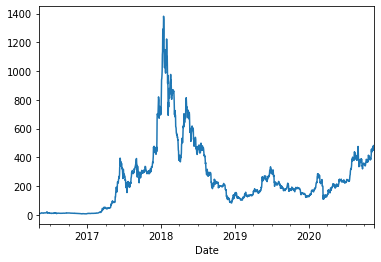

In [4]:
df['Close'].plot()

In [5]:
df.index.max()

Timestamp('2020-11-20 00:00:00')

In [6]:
# Block
test_cutoff_date = df.index.max() - timedelta(days=90)

df_test = df[df.index > test_cutoff_date]['Close']
df_train = df[df.index <= test_cutoff_date]['Close']


Single Step

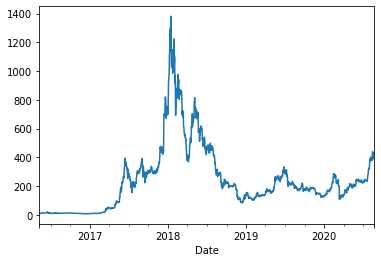

In [7]:
df_train.plot()

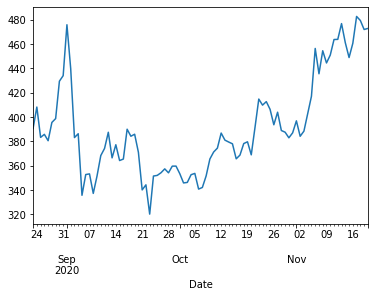

In [8]:
df_test.plot()

In [9]:
from numpy import array

# Block

def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps
		if end_ix > len(sequence)-1:
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

raw_seq = df_train
n_steps = 30

X, y = split_sequence(raw_seq, n_steps)

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [10]:
X.shape

(1537, 30, 1)

In [11]:
y.shape

(1537,)

In [12]:
# CNN 모델을 만드는 부분.
# TCN (Temporal Conv. NN)
model = keras.Sequential()
                       # 요약된 정보의 차원 갯수, 요약을 할 time window의 크기.  
                       #  30, 1
model.add(layers.Conv1D(
    filters=64, # 요약된 정보의 차원의 갯수
    kernel_size=2, # 요약을 할 time window의 크기. 
    activation='relu', 
    input_shape=(n_steps, 1))) # 29, 64
model.add(layers.MaxPooling1D(pool_size=2)) # 14,64
model.add(layers.Conv1D(
    filters=128, 
    kernel_size=2, 
    activation='relu')) # 13,128
model.add(layers.MaxPooling1D(pool_size=2)) # 6,128
model.add(layers.Conv1D(
    filters=256,
    kernel_size=2, 
    activation='relu')) # 5, 256
model.add(layers.MaxPooling1D(pool_size=2)) # 2, 256
model.add(layers.Flatten()) # 512
model.add(layers.Dense(50, activation='relu')) # 뉴럴 네트워크
model.add(layers.Dense(1))

        # 그라이언트를 계산
# model.compile(optimizer='adam', loss='mae')
model.compile(optimizer='adam', loss='mse')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 64)            192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 13, 128)           16512     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 6, 128)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 256)            65792     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 2, 256)           0

In [14]:
history = model.fit(X, y, epochs=100, batch_size=64)

Epoch 1/100
25/25 [==============================] - 1s 11ms/step - loss: 21603.4199
Epoch 2/100
25/25 [==============================] - 0s 12ms/step - loss: 8058.1167
Epoch 3/100
25/25 [==============================] - 0s 11ms/step - loss: 6994.2129
Epoch 4/100
25/25 [==============================] - 0s 11ms/step - loss: 6956.4995
Epoch 5/100
25/25 [==============================] - 0s 10ms/step - loss: 6304.6694
Epoch 6/100
25/25 [==============================] - 0s 11ms/step - loss: 6112.5815
Epoch 7/100
25/25 [==============================] - 0s 11ms/step - loss: 6482.5503
Epoch 8/100
25/25 [==============================] - 0s 11ms/step - loss: 6052.4404
Epoch 9/100
25/25 [==============================] - 0s 15ms/step - loss: 7980.2603
Epoch 10/100
25/25 [==============================] - 0s 17ms/step - loss: 5508.4072
Epoch 11/100
25/25 [==============================] - 0s 17ms/step - loss: 5235.7676
Epoch 12/100
25/25 [==============================] - 0s 18ms/step - loss

In [15]:
train_pred = model.predict(X)

49/49 [==============================] - 0s 3ms/step


In [16]:
train_pred

array([[ 25.220236],
       [ 25.440357],
       [ 25.375582],
       ...,
       [373.0762  ],
       [425.95834 ],
       [440.24115 ]], dtype=float32)

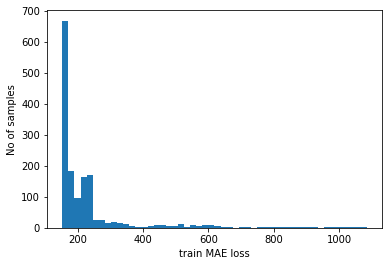

In [17]:
train_mae_loss = np.mean(np.abs(train_pred - y), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [18]:
train_df_with_pred = df_train.to_frame()[n_steps:]
train_df_with_pred['pred'] = train_pred

In [19]:
train_df_with_pred

,Close,pred
Date,,
2016-06-08,14.51,25.220236
2016-06-09,14.47,25.440357
2016-06-10,13.97,25.375582
2016-06-11,14.11,25.535011
2016-06-12,15.75,25.567921
...,...,...
2020-08-18,422.30,394.789856
2020-08-19,407.55,373.690918
2020-08-20,414.53,373.076202


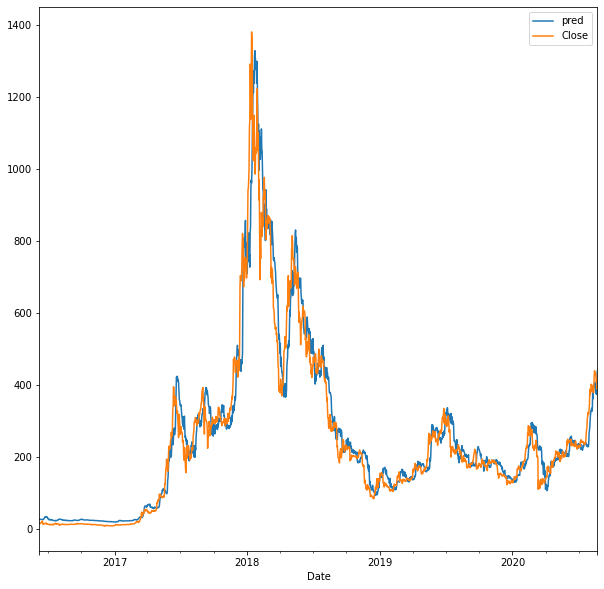

In [20]:
# Lagging = 예측값이 실제 값보다 N 스텝 앞에 있는 경우
# Forwarding = 예측값이 실제 값보다 N 스텝 뒤에 있는 경우
fig, ax = plt.subplots(figsize=(10,10))
train_df_with_pred['pred'].plot(ax=ax, legend=True)
train_df_with_pred['Close'].plot(ax=ax, legend=True)

In [21]:
test_raw_seq = df_test

test_X, test_y = split_sequence(test_raw_seq, n_steps)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [22]:
test_X.shape

(60, 30, 1)

In [23]:
y_pred = model.predict(test_X)

2/2 [==============================] - 0s 6ms/step


In [24]:
y_pred.shape

(60, 1)

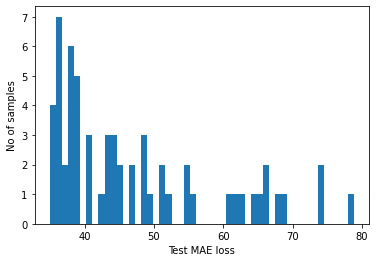

In [25]:
test_mae_loss = np.mean(np.abs(y_pred - test_y), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel("Test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [26]:
test_df_with_pred = df_test.to_frame()[n_steps:]
test_df_with_pred['pred'] = y_pred

In [27]:
test_df_with_pred

,Close,pred
Date,,
2020-09-22,344.17,400.504120
2020-09-23,320.06,366.930542
2020-09-24,351.40,392.712494
2020-09-25,351.94,350.509644
2020-09-26,354.10,340.172516
2020-09-27,357.31,355.834534
2020-09-28,354.06,345.554626
2020-09-29,359.55,347.683380
2020-09-30,359.59,326.912231


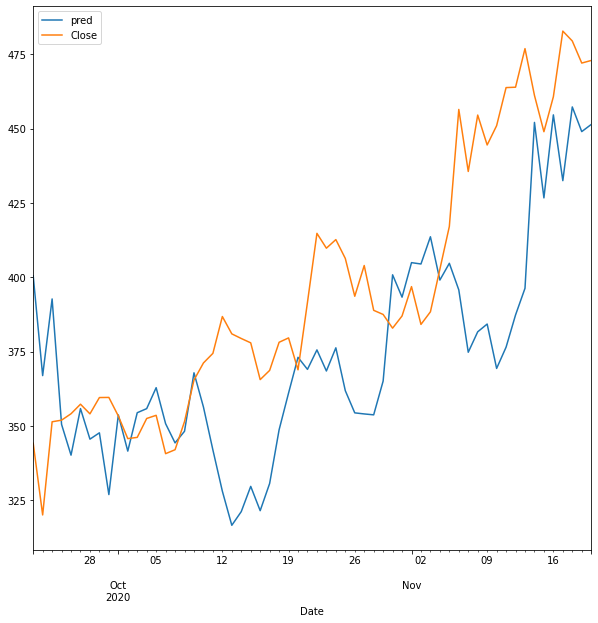

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
test_df_with_pred['pred'].plot(ax=ax, legend=True)
test_df_with_pred['Close'].plot(ax=ax, legend=True)

Multi Step

In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		if out_end_ix > len(sequence):
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
raw_seq = df_train

n_steps_in, n_steps_out = 60, 7
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
X.shape

(1501, 60, 1)

In [ ]:
model = keras.Sequential()
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
# 모델을 추가. (Seq2seq, Encoder-Decoder)
# 내가 출력할 시계열에 어떤 특징이 없을때
model.add(layers.Dense(n_steps_out))
model.compile(optimizer='adam', loss='mae')
# model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 59, 64)            192       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 29, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1856)              0         
                                                                 
 dense_2 (Dense)             (None, 50)                92850     
                                                                 
 dense_3 (Dense)             (None, 7)                 357       
                                                                 
Total params: 93,399
Trainable params: 93,399
Non-trainable params: 0
__________________________________________________

In [ ]:
history = model.fit(X, y, epochs=100)

Epoch 1/100
47/47 [==============================] - 1s 5ms/step - loss: 71.5031
Epoch 2/100
47/47 [==============================] - 0s 4ms/step - loss: 39.9305
Epoch 3/100
47/47 [==============================] - 0s 4ms/step - loss: 35.1119
Epoch 4/100
47/47 [==============================] - 0s 4ms/step - loss: 33.6355
Epoch 5/100
47/47 [==============================] - 0s 4ms/step - loss: 31.9250
Epoch 6/100
47/47 [==============================] - 0s 5ms/step - loss: 31.0863
Epoch 7/100
47/47 [==============================] - 0s 5ms/step - loss: 29.6755
Epoch 8/100
47/47 [==============================] - 0s 4ms/step - loss: 30.4280
Epoch 9/100
47/47 [==============================] - 0s 4ms/step - loss: 29.3942
Epoch 10/100
47/47 [==============================] - 0s 4ms/step - loss: 29.9303
Epoch 11/100
47/47 [==============================] - 0s 4ms/step - loss: 28.2522
Epoch 12/100
47/47 [==============================] - 0s 4ms/step - loss: 29.6102
Epoch 13/100
47/47 [=====

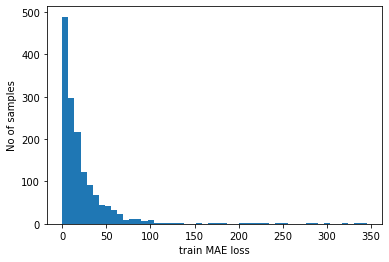

In [ ]:
train_pred = model.predict(X)

train_mae_loss = np.mean(np.abs(train_pred - y), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [ ]:
train_pred.shape

(1501, 7)

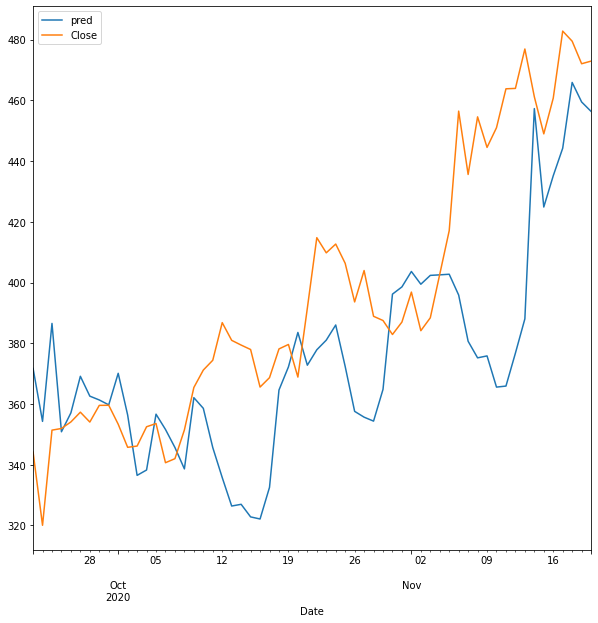

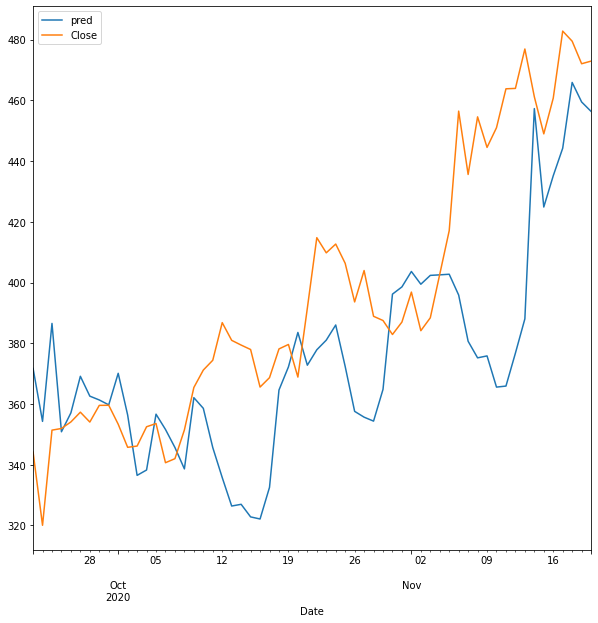

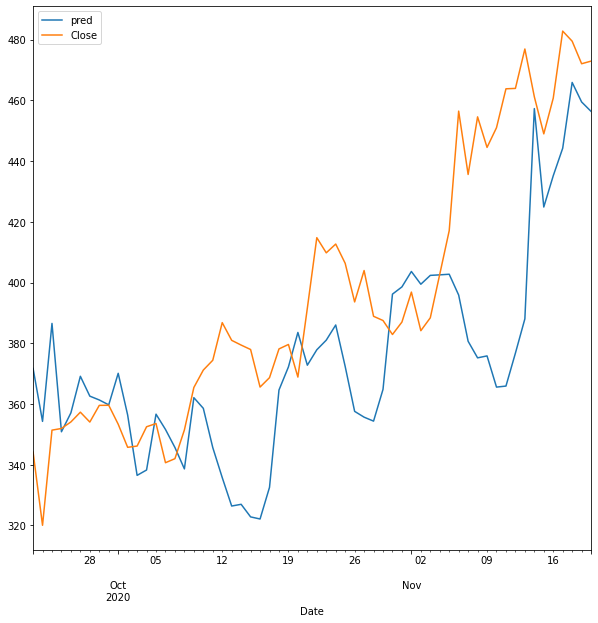

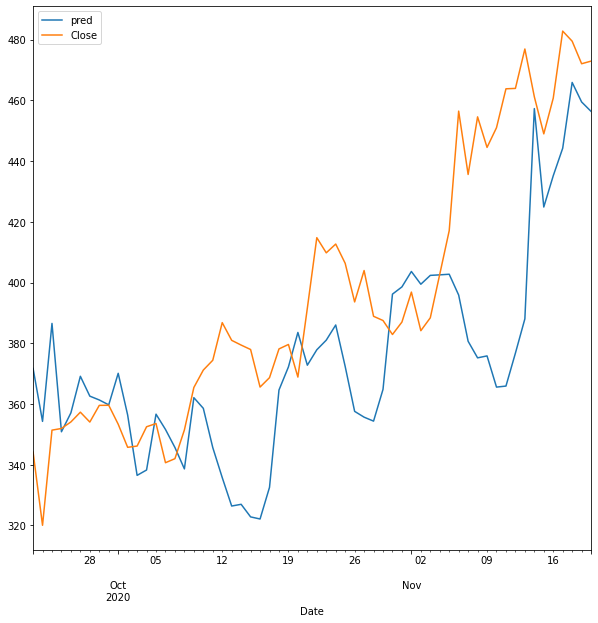

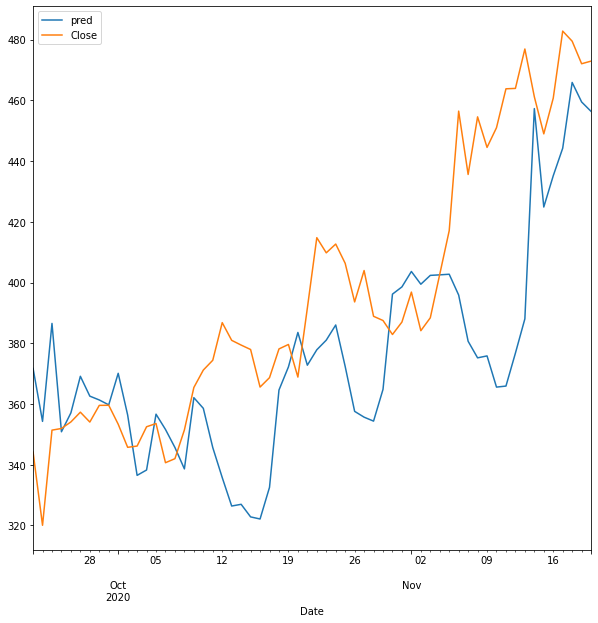

In [ ]:
for i, pred in enumerate(train_pred[:5]):
  train_df_with_pred = df_train[i:i+n_steps_out]
  train_df_with_pred['pred'] = pred
  
  fig, ax = plt.subplots(figsize=(10,10))
  test_df_with_pred['pred'].plot(ax=ax, legend=True)
  test_df_with_pred['Close'].plot(ax=ax, legend=True)
  plt.show()

In [ ]:
# TODO: TEST에 대해서도 똑같은 검증을 해보세요.